In [58]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

config = {
        "pretrained_name": "google/vit-base-patch16-224",
        "results_path": "/scratch365/dpan/new_results/ig",
        "max_samples": 100,
        "dataset_split": "tiny",
        "num_samples": 1000,
        "batch_size":1,
}

In [2]:
from maskgen.utils.model_utils import get_pred_model

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and processor
pretrained_name = config['pretrained_name']
processor, target_model = get_pred_model(pretrained_name, device)

print("target model loaded")

target model loaded


In [49]:
from maskgen.utils.image_utils import get_image_example


image = get_image_example(2)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)
print("Predicted class:", target_model.config.id2label[predicted_class_idx])

Predicted class: Siamese cat, Siamese


In [50]:
wrapper_model = lambda x: target_model(x).logits

In [51]:
from captum.attr import IntegratedGradients
from maskgen.baselines.gradshap import downsample_attribution

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values.to(device)

# Initialize analyzer with wrapped model
ig = IntegratedGradients(wrapper_model)


# Get attribution for single image
attribution_ig = ig.attribute(pixel_values, target=predicted_class_idx, n_steps=100)
attribution_map = downsample_attribution(attribution_ig.squeeze(0), patch_size=16)


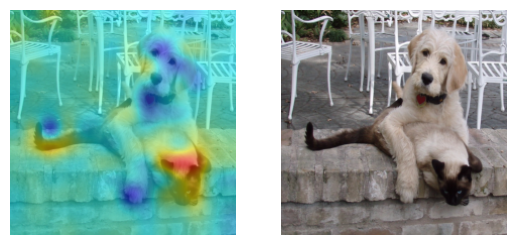

In [52]:
from maskgen.utils.img_utils import plot_overlap_np
heatmap = attribution_map.detach().cpu().numpy()
img = pixel_values.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, processor.image_mean, processor.image_mean)

In [54]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils.data_utils import get_imagenet_dataloader

# get dataloader
dataloader = get_imagenet_dataloader(split='tiny', 
                                    batch_size=config['batch_size'], 
                                    processor=processor, 
                                    shuffle=False,
                                    num_samples=config['num_samples'])

Repo card metadata block was not found. Setting CardData to empty.


In [55]:
all_inputs = []
all_heatmaps = []

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Processing batches"):
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)
    # Get attribution for single image
    with torch.no_grad():
        predicted_class_idx = target_model(pixel_values).logits.argmax(-1).item()
    
    attribution_ig = ig.attribute(pixel_values, target=predicted_class_idx, n_steps=100)
    attribution_map = downsample_attribution(attribution_ig.squeeze(0), patch_size=16)

    inputs_np = pixel_values.cpu().numpy()
    heatmap_np = attribution_map.cpu().numpy()
    all_inputs.append(inputs_np)
    all_heatmaps.append(heatmap_np)

all_inputs = np.concatenate(all_inputs, axis=0)
all_heatmaps = np.concatenate(all_heatmaps, axis=0)
    

Processing batches: 100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [56]:
all_heatmaps = [heatmap.cpu().numpy() for heatmap in all_heatmaps]

In [59]:
from maskgen.utils.save_utils import save_pixel_heatmap_pairs

save_path = config['results_path']
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_path = os.path.join(save_path, 'pixel_heatmap_pairs.npz')
save_pixel_heatmap_pairs(all_inputs, all_heatmaps, save_path)